# Projet 3: Anomaly Detection

## Library imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_curve, auc

import os   

## Modeles 

- Colorization Autoencoder
- Inpainting Autoencoder
- Masked Autoencoder
- Contrastive Encoder

Les 3 premiers sont issu d'un autoencoder similaire. La pretexte taches est modifiée.

Tous se base sur un encoder de type ResNet18. L'interet d'un encoder unique est de pouvoir comparer au mieux les 4 méthodes. 
Resnet18 a été utilisé car il a démontré de bon résultat pour l'extraction d'anomali. Bien que moins performant que d'autres modeles (Resnet50, AUTRE EXEMPLE), il est plus léger et a donc une vitesse d'execution plus rapide. On souhaite effectuer une comparaison, alors, il ne s'agit pas de se concentrer uniquement sur les performances de précision.

# Hyperparameters

In [2]:
BATCH_SIZE = 128
RESIZE = 32
LATENT_DIM = 32

## Data Preparation

### Download the datasets

Les données ont été convertit de png à jpg pour diminuer largement la taille des données (de 5,1Go à 165Mo) et augmenter largement la vitesse de calcul.
Les performance sont moins bonnes, cependant comme il s'agit d'une étude comparative et non une étude de performance, on s'attends à avoir une diminution de performance globale, ce qui n'est donc pas dérangeant car un modèle n'est pas favorisé plus qu'un autre. Il est donc possible de faire une comparaison des modèles.
A la fin, une étude de performance sera effectué avec le modèle le plus prometeur. 

Les datasets ont été modifiés pour correspondre aux demandes du projet et son téléchargeable depuis un dépot github séparé du code.

In [3]:
# Crée un chemin relatif basé sur le dossier actuel
dataset_path = os.path.join(os.getcwd(), '../data/')

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path, exist_ok=True)  # Crée le dossier et ses parents si nécessaire

    !git clone https://github.com/sourisimos/DATA_P3HDDL_MVTEC.git ../data/mvtec #Cloning mvtec dataset 
    !git clone https://github.com/sourisimos/DATA_P3HDDL_EW.git ../data/ew #Cloning ew datasets

    print(f"Dossiers téléchargés dans le dossier '{dataset_path}'.")


## Engine wiring dataset

### jpg dataset


In [4]:
# Define the transformations to apply to EW

transform_ew_val = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor()

])

transform_ew_train = transforms.Compose([
    transforms.Resize((RESIZE,RESIZE)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])


# Load EW dataset for train test and creating val
# Training
ew_train_dataset = datasets.ImageFolder(root='../data/ew/engine_wiring/train', transform=transform_ew_train)
ew_train_loader = DataLoader(ew_train_dataset, batch_size=BATCH_SIZE, shuffle=True )

# Test
ew_test_dataset = datasets.ImageFolder(root='../data/ew/engine_wiring/test', transform=transform_ew_val) 
ew_test_loader = DataLoader(ew_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### png DATASET


In [6]:
# Define the transformations to apply to EW

transform_ew_val = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor()

])

transform_ew_train = transforms.Compose([
    transforms.Resize((RESIZE,RESIZE)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])


# Load EW dataset for train test and creating val
# Training
ew_train_dataset = datasets.ImageFolder(root='../data_png/engine_wiring/train', transform=transform_ew_train)
ew_train_loader = DataLoader(ew_train_dataset, batch_size=BATCH_SIZE, shuffle=True )

# Test
ew_test_dataset = datasets.ImageFolder(root='../data_png/engine_wiring/test', transform=transform_ew_val) 
ew_test_loader = DataLoader(ew_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## MVtec datasets

In [5]:
# Define the transformations to apply to the images
transform_mvtec = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
])

# Function to load the dataset mvtec 
def load_mvt_dataset(root='../data/mvtec/mvtec_anomaly_detection', batch_size=64, restricted = True):
    # List of categories you want to load
    categories = ['bottle', 'cable','capsule', 'carpet', 'grid','hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']  # Add other categories as needed
    # Restricted are just the essential one (for the academ project )
    if restricted: 
        categories = ['bottle','capsule', 'hazelnut', 'toothbrush']
        
    # Create dictionaries to hold loaders for training and test sets
    train_loaders = {}
    test_loaders = {}
    
    for category in categories:

        train_dataset = datasets.ImageFolder(root=f'{root}/{category}/train', transform=transform_mvtec)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_loaders[category] = train_loader
        
        test_dataset = datasets.ImageFolder(root=f'{root}/{category}/test', transform=transform_mvtec)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        test_loaders[category] = test_loader
        
    return train_loaders, test_loaders

train_loaders, test_loaders = load_mvt_dataset()

# Accessing a specific category's data loader
bottle_train_loader = train_loaders['bottle']
bottle_test_loader = test_loaders['bottle']

## Shared architecture
We will create a shared architecture with the following layers:
- The encoder (in sequential order):
    - A convolution with 64 filters, kernel size 4, stride 2, padding 1
    - A ReLU activation
    - A convolution with 128 filters, kernel size 4, stride2, padding 1
    - A ReLU activation
    - A convolution with `latent_dim`, kernel size 4, stride 2, padding 1
    - A ReLU activation
The encoder should take the number of channels of the input `in_channels` and the hidden dimension `latent_dim` as arguments.
- The decoder (in secuential ) order:
    - A Transpose convolution with 128 filters, kernel size 4, padding 1
    - A ReLU activation
    - A convolution with 16428 filters, kernel size 4, stride2, padding 1
    - A ReLU activation
    - A convolution with `out_channels` filters, kernel size 4, stride 2, padding 1
    - A ReLU activation
The encoder should take the number of channels of the output `out_channels` and the hidden dimension `latent_dim` as arguments.

In [6]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=128):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Conv2d(256, latent_dim, kernel_size=4, stride=2, padding=1),  # 4x4 -> 2x2
            nn.ReLU(),
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=128, out_channels=3):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)

In [7]:
from torchvision.models import resnet18

class ResNet18Encoder(nn.Module):
    def __init__(self, in_channels, pretrained=True):
        super(ResNet18Encoder, self).__init__()
        assert in_channels in [1, 3], "Seuls 1 ou 3 canaux sont supportés pour le moment."

        resnet = resnet18(pretrained=pretrained)
        old_conv1 = resnet.conv1  # Conserver les anciens paramètres

        # Nouvelle couche convolutive avec le bon nombre de canaux
        resnet.conv1 = nn.Conv2d(in_channels, old_conv1.out_channels,
                                 kernel_size=old_conv1.kernel_size,
                                 stride=old_conv1.stride,
                                 padding=old_conv1.padding,
                                 bias=old_conv1.bias is not None)

        # Copier les poids des canaux existants si l'entrée a 1 canal (par ex., niveaux de gris)
        if in_channels == 1:
            resnet.conv1.weight.data = old_conv1.weight.data.mean(dim=1, keepdim=True)

        # Garder uniquement les couches convolutives jusqu'à la dernière convolution
        self.features = nn.Sequential(*list(resnet.children())[:-2])  # Jusqu'à "avgpool"

    def forward(self, x):
        return self.features(x)


class ResNet18Decoder(nn.Module):
    def __init__(self, out_channels):
        super(ResNet18Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.Sigmoid()  # Contraindre la sortie dans [0, 1]
        )

    def forward(self, x):
        return self.decoder(x)


In [8]:
def train_ssl_model(model, 
                    train_loader, 
                    val_loader, 
                    criterion,
                    optimizer,
                    device=device,
                    epochs=5):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            
            output, _ = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                output, _ = model(images)
                val_loss = criterion(output, images)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")
    
    return model

# Colorization model 

a de grande chance d'être nul dans le cadre de nos données

In [22]:
class ColorizationResNetModel(nn.Module):
    def __init__(self):
        super(ColorizationResNetModel, self).__init__()
        self.encoder = ResNet18Encoder(in_channels=1)  # Input grayscale
        self.decoder = ResNet18Decoder(out_channels=3)  # Predict RGB

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        z = self.encoder(grayscale_x)
        return self.decoder(z), grayscale_x

In [ ]:
class ColorizationModel(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(ColorizationResNetModel, self).__init__()
        self.encoder = Encoder(in_channels=1, latent_dim = LATENT_DIM)  # Input grayscale
        self.decoder = Decoder(out_channels=3, latent_dim = LATENT_DIM)  # Predict RGB

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        z = self.encoder(grayscale_x)
        return self.decoder(z), grayscale_x

In [23]:
colorization_rensetmodel = ColorizationResNetModel()
colorization_resnetencoder = train_ssl_model(colorization_rensetmodel, 
                                       bottle_train_loader, 
                                       bottle_test_loader, 
                                       criterion=nn.MSELoss(), 
                                       optimizer=optim.Adam(colorization_rensetmodel.parameters(),lr=0.01),
                                       epochs = 20
                                       )

Epoch 1/20, Train Loss: 0.1894, Avg Val Loss: 0.3636
Epoch 2/20, Train Loss: 0.1249, Avg Val Loss: 0.3767
Epoch 3/20, Train Loss: 0.0993, Avg Val Loss: 0.3242
Epoch 4/20, Train Loss: 0.0548, Avg Val Loss: 0.2957
Epoch 5/20, Train Loss: 0.0227, Avg Val Loss: 0.2808
Epoch 6/20, Train Loss: 0.0149, Avg Val Loss: 0.2538
Epoch 7/20, Train Loss: 0.0129, Avg Val Loss: 0.1867
Epoch 8/20, Train Loss: 0.0119, Avg Val Loss: 0.1325
Epoch 9/20, Train Loss: 0.0103, Avg Val Loss: 0.0851
Epoch 10/20, Train Loss: 0.0088, Avg Val Loss: 0.0596
Epoch 11/20, Train Loss: 0.0082, Avg Val Loss: 0.0437
Epoch 12/20, Train Loss: 0.0077, Avg Val Loss: 0.0399
Epoch 13/20, Train Loss: 0.0073, Avg Val Loss: 0.0326
Epoch 14/20, Train Loss: 0.0070, Avg Val Loss: 0.0264
Epoch 15/20, Train Loss: 0.0069, Avg Val Loss: 0.0234
Epoch 16/20, Train Loss: 0.0067, Avg Val Loss: 0.0146
Epoch 17/20, Train Loss: 0.0065, Avg Val Loss: 0.0112
Epoch 18/20, Train Loss: 0.0065, Avg Val Loss: 0.0088
Epoch 19/20, Train Loss: 0.0063, Avg 

In [ ]:
colorization_model = ColorizationModel(latent_dim=LATENT_DIM)
colorization_encoder = train_ssl_model(colorization_model, 
                                       bottle_train_loader, 
                                       bottle_test_loader, 
                                       criterion=nn.MSELoss(), 
                                       optimizer=optim.Adam(colorization_model.parameters(),lr=0.01),
                                       epochs = 20
                                       )

# Inpainting model 

In [11]:
class InpaintingModel(nn.Module):
    def __init__(self, latent_dim=128, mask_size=8):
        super(InpaintingModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_size = mask_size

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
    
    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)):
            ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
            ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)
            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0

        return masked_x

In [26]:
inpainting_model = InpaintingModel(latent_dim=LATENT_DIM, mask_size=8)
inpainting_encoder = train_ssl_model(inpainting_model,
                                     bottle_train_loader, 
                                     bottle_test_loader, 
                                     criterion=nn.MSELoss(), 
                                     optimizer=optim.Adam(inpainting_model.parameters(),lr=0.001),
                                     epochs = 20
                                     )

Epoch 1/20, Train Loss: 0.1308, Avg Val Loss: 0.1265
Epoch 2/20, Train Loss: 0.1147, Avg Val Loss: 0.0722
Epoch 3/20, Train Loss: 0.0695, Avg Val Loss: 0.0553
Epoch 4/20, Train Loss: 0.0627, Avg Val Loss: 0.0505
Epoch 5/20, Train Loss: 0.0455, Avg Val Loss: 0.0399
Epoch 6/20, Train Loss: 0.0305, Avg Val Loss: 0.0289
Epoch 7/20, Train Loss: 0.0218, Avg Val Loss: 0.0216
Epoch 8/20, Train Loss: 0.0177, Avg Val Loss: 0.0143
Epoch 9/20, Train Loss: 0.0141, Avg Val Loss: 0.0136
Epoch 10/20, Train Loss: 0.0126, Avg Val Loss: 0.0128
Epoch 11/20, Train Loss: 0.0108, Avg Val Loss: 0.0099
Epoch 12/20, Train Loss: 0.0088, Avg Val Loss: 0.0089
Epoch 13/20, Train Loss: 0.0075, Avg Val Loss: 0.0077
Epoch 14/20, Train Loss: 0.0065, Avg Val Loss: 0.0069
Epoch 15/20, Train Loss: 0.0057, Avg Val Loss: 0.0059
Epoch 16/20, Train Loss: 0.0049, Avg Val Loss: 0.0053
Epoch 17/20, Train Loss: 0.0043, Avg Val Loss: 0.0050
Epoch 18/20, Train Loss: 0.0039, Avg Val Loss: 0.0044
Epoch 19/20, Train Loss: 0.0035, Avg 

# Masked AE Model

In [28]:
class MaskedAutoencoderModel(nn.Module):
    def __init__(self, mask_ratio=1/16):
        super(MaskedAutoencoderModel, self).__init__()
        self.encoder = ResNet18Encoder(in_channels=3)
        self.decoder = ResNet18Decoder(out_channels=3)
        self.mask_ratio = mask_ratio

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
        
    
    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)
        x_masked[mask] = 0
        return x_masked

In [30]:
mae_model = MaskedAutoencoderModel(mask_ratio=1/16)
mae_encoder = train_ssl_model(mae_model,
                              bottle_train_loader, 
                              bottle_test_loader, 
                              criterion=nn.MSELoss(), 
                              optimizer=optim.Adam(mae_model.parameters(),lr=0.001),
                              epochs = 20
                              )

/home/hp/miniconda3/envs/HDDL/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hp/miniconda3/envs/HDDL/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.1234, Avg Val Loss: 0.1184
Epoch 2/20, Train Loss: 0.1020, Avg Val Loss: 0.1169
Epoch 3/20, Train Loss: 0.0941, Avg Val Loss: 0.1064
Epoch 4/20, Train Loss: 0.0893, Avg Val Loss: 0.0979
Epoch 5/20, Train Loss: 0.0836, Avg Val Loss: 0.0838
Epoch 6/20, Train Loss: 0.0672, Avg Val Loss: 0.0516
Epoch 7/20, Train Loss: 0.0358, Avg Val Loss: 0.0240
Epoch 8/20, Train Loss: 0.0175, Avg Val Loss: 0.0114
Epoch 9/20, Train Loss: 0.0086, Avg Val Loss: 0.0111
Epoch 10/20, Train Loss: 0.0056, Avg Val Loss: 0.0165
Epoch 11/20, Train Loss: 0.0047, Avg Val Loss: 0.0159
Epoch 12/20, Train Loss: 0.0042, Avg Val Loss: 0.0142
Epoch 13/20, Train Loss: 0.0038, Avg Val Loss: 0.0099
Epoch 14/20, Train Loss: 0.0035, Avg Val Loss: 0.0075
Epoch 15/20, Train Loss: 0.0034, Avg Val Loss: 0.0049
Epoch 16/20, Train Loss: 0.0032, Avg Val Loss: 0.0042
Epoch 17/20, Train Loss: 0.0030, Avg Val Loss: 0.0043
Epoch 18/20, Train Loss: 0.0029, Avg Val Loss: 0.0047
Epoch 19/20, Train Loss: 0.0027, Avg 

# Contrastive Model

#### Dataset

In [9]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]
    
# Define the transformations to apply to the images
contrast_transform = transforms.Compose([ transforms.Resize((128, 128)), # fait à la fin pour conserver le plus d'infos lors des étapes de transfo
                                          transforms.RandomHorizontalFlip(),
                                           transforms.RandomResizedCrop(size=128),
#                                          transforms.RandomApply([
#                                              transforms.ColorJitter(brightness=0.5,
#                                                                     contrast=0.5,
#                                                                     saturation=0.5,
#                                                                     hue=0.1)
#                                          ], p=0.8),
#                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                         ])

# Function to load the dataset mvtec 
def load_mvt_dataset_cm(root='../data/mvtec/mvtec_anomaly_detection', batch_size=64, restricted = True):
    # List of categories you want to load
    categories = ['bottle', 'cable','capsule', 'carpet', 'grid','hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']  # Add other categories as needed
    # Restricted are just the essential one (for the academ project )
    if restricted: 
        categories = ['bottle','capsule', 'hazelnut', 'toothbrush']
        
    # Create dictionaries to hold loaders for training and test sets
    train_loaders = {}
    test_loaders = {}
    
    for category in categories:

        train_dataset = datasets.ImageFolder(root=f'{root}/{category}/train', transform=ContrastiveTransformations(contrast_transform))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_loaders[category] = train_loader
        
        test_dataset = datasets.ImageFolder(root=f'{root}/{category}/test', transform=ContrastiveTransformations(contrast_transform))
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        test_loaders[category] = test_loader
        
    return train_loaders, test_loaders

train_loaders_cm, test_loaders_cm = load_mvt_dataset_cm()

# Accessing a specific category's data loader
bottle_train_loader_cm = train_loaders_cm['hazelnut']
bottle_test_loader_cm = test_loaders_cm['hazelnut']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


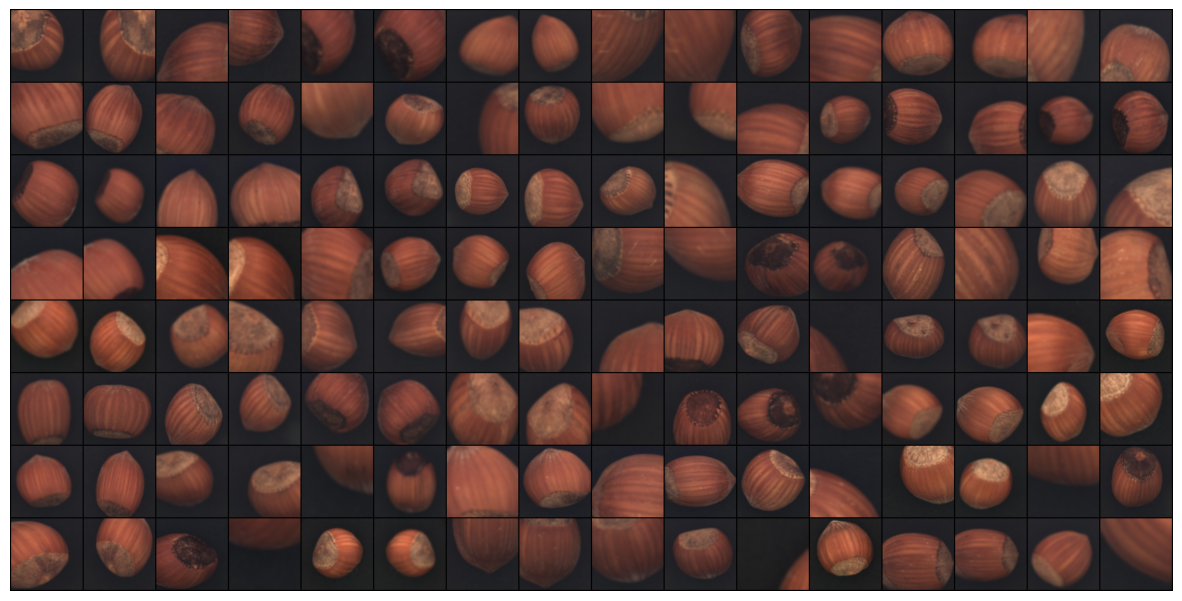

In [47]:
# Vérification des transformations
import matplotlib.pyplot as plt
import torchvision

# Récupérer un batch d'images
data_iter = iter(bottle_train_loader_cm)
(img1, img2), labels = next(data_iter)  # images contient le batch, labels les classes associées
print(labels)
images = torch.cat([torch.stack([img1[i], img2[i]]) for i in range(img1.size(0))], dim=0)# Faire une grille d'images
grid_img = torchvision.utils.make_grid(images, nrow=2*8)  # nrow = nombre d'images par ligne

# Convertir en numpy et afficher
plt.figure(figsize=(15, 15))  # Ajuster la taille de l'affichage
plt.imshow(grid_img.permute(1, 2, 0))  # PyTorch utilise (C, H, W), Matplotlib attend (H, W, C)
plt.axis('off')  # Enlever les axes pour une visualisation propre
plt.show()

#### Contrastive model

In [11]:
# Define the Projection Head
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class ContrastiveModel(nn.Module):
    def __init__(self, in_channels=3, latent_dim=32, projection_dim=128):
        super(ContrastiveModel, self).__init__()
        self.encoder = Encoder(in_channels=in_channels, latent_dim=latent_dim)
        
        # Ajustez input_dim en fonction de la sortie de l'encodeur
        # En supposant que la sortie de l'encodeur est de dimension (256, 2, 2)
        input_dim = 512 * 2 * 2
        self.projection_head = ProjectionHead(input_dim=input_dim, output_dim=projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        features_flat = features.view(features.size(0), -1)
        projections = self.projection_head(features_flat)
        return F.normalize(projections, p=2, dim=1) 


In [17]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Ajout BatchNorm
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))  # Appliquer BatchNorm après fc1
        return self.fc2(x)


# Encoder basé sur ResNetz
class Contrastive_Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Contrastive_Encoder, self).__init__()
        resnet = resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
        self.fc = nn.Linear(resnet.fc.in_features, latent_dim)

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        return self.fc(features)

# Modèle complet
class ContrastiveModel(nn.Module):
    def __init__(self, latent_dim=512, projection_dim=64):
        super(ContrastiveModel, self).__init__()
        self.encoder = Contrastive_Encoder(latent_dim=latent_dim)
        self.projection_head = ProjectionHead(input_dim=latent_dim, output_dim=projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return F.normalize(projections, p=2, dim=1)

#### Contrastiv_loss

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def SSLContrastiveLoss(z1, z2, margin=0.5):

    """
    Args:
        z_i: Tensor des embeddings des transformations de l'image initiale (batch_size, embedding_dim)
        z_j: Tensor des embeddings des autres transformations correspondantes (batch_size, embedding_dim)
    
    Returns:
        loss: Scalar tensor représentant la perte contrastive.
    """
    z1 = F.normalize(z1, p=2, dim=1)  # Normalisation des embeddings
    z2 = F.normalize(z2, p=2, dim=1)
    
    batch_size = z1.size(0)

    all_distances = torch.cdist(z1, z2, p=2)

    # Séparation des distances positives et négatives
    mask = torch.eye(batch_size, device=z1.device).bool()  # Masque pour les paires positives
    pos_distances = all_distances[mask]  # Distances positives (diagonale)
    neg_distances = all_distances[~mask]  # Distances négatives (hors diagonale)

    # Contrastive loss computation
    pos_loss = torch.mean(pos_distances**2)  # Positive pair loss
    # Normalisation par le nombre de paires

    
    num_negatives = neg_distances.numel()
    neg_loss = torch.sum(torch.clamp(margin - neg_distances, min=0.0)**2) / num_negatives

    # neg_loss = torch.mean(torch.clamp(margin - neg_distances, min=0.0)**2)  # Negative pair loss

    # Total loss
    loss = pos_loss

    return loss


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def SSLContrastiveLossCosine(z1, z2, margin=0.5):
    """
    Contrastive loss utilisant la similarité cosinus.

    Args:
        z1 (Tensor): Embeddings des transformations de l'image initiale (batch_size, embedding_dim).
        z2 (Tensor): Embeddings des autres transformations correspondantes (batch_size, embedding_dim).
        margin (float): Marge à appliquer pour séparer les paires négatives.

    Returns:
        loss (Tensor): Perte scalaire contrastive.
    """
    z1 = F.normalize(z1, p=2, dim=1)  # Normalisation des embeddings
    z2 = F.normalize(z2, p=2, dim=1)

    batch_size = z1.size(0)

    # Calculer la similarité cosinus entre toutes les paires
    all_similarities = torch.mm(z1, z2.T)  # Produit scalaire après normalisation (équivaut à cosine_similarity)

    # Masque pour les paires positives (diagonale)
    mask = torch.eye(batch_size, device=z1.device).bool()
    pos_similarities = all_similarities[mask]  # Similarité des paires positives (diagonale)
    neg_similarities = all_similarities[~mask]  # Similarité des paires négatives (hors diagonale)

    # Perte pour les paires positives : Maximiser la similarité (1 - cos_sim)
    pos_loss = torch.mean(1 - pos_similarities)

    # Perte pour les paires négatives : Minimiser la similarité si elle dépasse la marge
    neg_loss = torch.mean(torch.clamp(neg_similarities - margin, min=0.0)**2)

    # Perte totale
    loss = pos_loss

    return loss


#### Contrastive training

In [35]:
# Training loop for contrastive learning
def train_contrastive_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for (b_img1, b_img2), _ in train_loader:
            b_img1, b_img2 = b_img1.to(device), b_img2.to(device)

            optimizer.zero_grad()
            z1 = model(b_img1)
            z2 = model(b_img2)

            loss = criterion(z1, z2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        """
        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for (img1, img2), _ in train_loader:
                img1, img2 = img1.to(device), img2.to(device)
                
                z1 = model(img1)
                z2 = model(img2)

                val_loss = criterion(z1, z2)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")
        """
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")
        



In [43]:
contrastiv_model = ContrastiveModel(projection_dim=128)

contrastiv_encoder = train_contrastive_model(contrastiv_model, 
                                            bottle_train_loader_cm, 
                                            bottle_test_loader_cm, 
                                            criterion=SSLContrastiveLossCosine, 
                                            optimizer=optim.Adam(contrastiv_model.parameters(),lr=1e-4),
                                            epochs = 20
                                            )

/home/hp/miniconda3/envs/HDDL/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hp/miniconda3/envs/HDDL/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.5762
Epoch 2/20, Train Loss: 0.4290
Epoch 3/20, Train Loss: 0.2982
Epoch 4/20, Train Loss: 0.2245
Epoch 5/20, Train Loss: 0.1604
Epoch 6/20, Train Loss: 0.1445
Epoch 7/20, Train Loss: 0.0943
Epoch 8/20, Train Loss: 0.0762
Epoch 9/20, Train Loss: 0.0634
Epoch 10/20, Train Loss: 0.0572
Epoch 11/20, Train Loss: 0.0516
Epoch 12/20, Train Loss: 0.0468
Epoch 13/20, Train Loss: 0.0425
Epoch 14/20, Train Loss: 0.0343
Epoch 15/20, Train Loss: 0.0344
Epoch 16/20, Train Loss: 0.0337
Epoch 17/20, Train Loss: 0.0296
Epoch 18/20, Train Loss: 0.0298
Epoch 19/20, Train Loss: 0.0301
Epoch 20/20, Train Loss: 0.0241


#### Contrastiv anomaly detection

In [21]:
import torch
from torch.utils.data import DataLoader

# Function to compute embeddings
def compute_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for x1, label in data_loader:
            z1 = model(x1)  # Use one augmented view for simplicity
            embeddings.append(z1)
            labels.extend(label.cpu().numpy())  # Convertir en numpy et ajouter à la liste
    embeddings = torch.cat(embeddings)
    return embeddings, labels

# Function to calculate anomaly scores
def compute_anomaly_scores(embeddings, normal_mean):
    distances = torch.norm(embeddings - normal_mean, dim=1)
    return distances


In [44]:
with torch.no_grad():
    embeddings_normales, _ = compute_embeddings(contrastiv_model, bottle_train_loader)
    embeddings_evaluation, labels = compute_embeddings(contrastiv_model, bottle_test_loader)

normal_mean = torch.mean(embeddings_normales, dim=0)

anomaly_scores = compute_anomaly_scores(embeddings_evaluation, normal_mean)

# Set a threshold (e.g., 95th percentile of normal distances)
# threshold = torch.quantile(anomaly_scores, 0.80)

from sklearn.metrics import f1_score

best_threshold = 0
best_f1 = 0
thresholds = torch.linspace(anomaly_scores.min(), anomaly_scores.max(), steps=100)

for t in thresholds:
    preds = (anomaly_scores > t).int()
    f1 = f1_score(labels, preds.cpu().numpy())
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# Predict anomalies
predictions  = (anomaly_scores > best_threshold).int()
predictions = predictions.cpu().numpy()
# Outputs for inspection
print(f"Anomaly Scores: {anomaly_scores}")
print(f"Threshold: {best_threshold}")
print(f"Predictions (1=anomaly, 0=normal): {predictions}")
print(labels)

Anomaly Scores: tensor([0.0284, 0.0315, 0.0327, 0.0371, 0.0348, 0.0246, 0.0677, 0.0508, 0.0269,
        0.0308, 0.0399, 0.0401, 0.0449, 0.0437, 0.0406, 0.0503, 0.0390, 0.0383,
        0.0392, 0.0490, 0.0640, 0.0481, 0.0872, 0.0787, 0.0535, 0.0599, 0.1329,
        0.0561, 0.0889, 0.1194, 0.0853, 0.0403, 0.0831, 0.0953, 0.0388, 0.0402,
        0.0930, 0.0992, 0.0902, 0.1264, 0.1009, 0.0859, 0.0480, 0.1113, 0.1409,
        0.0760, 0.0991, 0.1011, 0.0744, 0.0879, 0.0774, 0.0939, 0.1100, 0.0509,
        0.0583, 0.1154, 0.1460, 0.1470, 0.1429, 0.0994, 0.0492, 0.1327, 0.0707,
        0.0572, 0.0649, 0.0663, 0.0586, 0.0887, 0.0868, 0.0486, 0.0966, 0.1479,
        0.0545, 0.1150, 0.0955, 0.0800, 0.0574, 0.0862, 0.0565, 0.0381, 0.0524,
        0.1025, 0.0668])
Threshold: 0.04574371501803398
Predictions (1=anomaly, 0=normal): [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1]
[0,

# Anomaly detection 

In [23]:
import torch
import torch.nn as nn

class AnomalyDetectionModel(nn.Module):
    def __init__(self, model):
        super(AnomalyDetectionModel, self).__init__()
        self.model = model  # Modèle de reconstruction pré-entraîné

    def forward(self, x):
        # Le modèle principal doit retourner une reconstruction
        # Si le modèle retourne un tuple, on ne garde que la reconstruction
        if isinstance(self.model(x), tuple):
            x_reconstructed, _ = self.model(x)
        else:
            x_reconstructed = self.model(x)
        return x_reconstructed

    def compute_anomaly_score(self, x):
        """
        Calcule le score d'anomalie pour chaque batch d'images.
        """
        x_reconstructed = self.forward(x)  # Reconstruction
        loss_fn = nn.MSELoss(reduction='none')  # MSE pixel par pixel
        per_pixel_loss = loss_fn(x_reconstructed, x)  # Perte pixel par pixel
        # Moyenne sur les dimensions des pixels (H, W, C) pour obtenir un score par image
        anomaly_score = per_pixel_loss.mean(dim=(1, 2, 3))
        return anomaly_score

    def evaluate_anomaly_detection(self, dataloader):

        self.model.eval()  # Mettre le modèle en mode évaluation
        scores = []  # Liste pour stocker les scores
        labels = []  # Liste pour stocker les labels
        with torch.no_grad():  # Pas de calcul des gradients
            for batch, label in dataloader:
                # Charger les données et les labels sur le bon appareil (CPU/GPU)
                x = batch.to(device)
                label = label.to(device)
                # Calculer les scores d'anomalie
                score = self.compute_anomaly_score(x)
                scores.extend(score.cpu().numpy())  # Convertir en numpy et ajouter à la liste
                labels.extend(label.cpu().numpy())  # Convertir en numpy et ajouter à la liste
        return scores, labels


In [24]:
def compute_anomaly_score(x_reconstructed, x):

    loss_fn = nn.MSELoss(reduction='none')  # MSE pixel par pixel
    per_pixel_loss = loss_fn(x_reconstructed, x)  # Perte pixel par pixel
    # Moyenne sur les dimensions des pixels (H, W, C) pour obtenir un score par image
    anomaly_score = per_pixel_loss.mean(dim=(1, 2, 3))
    return anomaly_score

In [25]:
def plot_roc_curve(y_true, y_scores):

    # Calcul des courbes ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Tracé de la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

Cosine avec neg 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


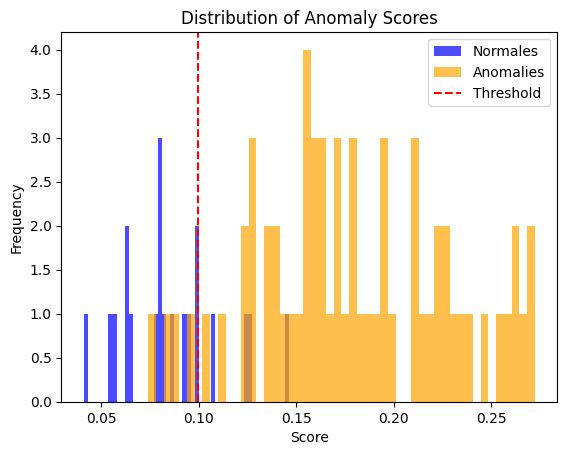

In [26]:
import matplotlib.pyplot as plt

# Convertir les scores et labels en numpy pour manipulation facile
anomaly_scores_np = anomaly_scores.cpu().numpy()
labels_np = np.array(labels)

print(labels)
# Séparer les scores selon les labels
scores_normales = anomaly_scores_np[labels_np == 0]
scores_anomalies = anomaly_scores_np[labels_np == 1]
plt.hist(scores_normales, bins=50, alpha=0.7, label="Normales", color="blue")
plt.hist(scores_anomalies, bins=50, alpha=0.7, label="Anomalies", color="orange")
plt.axvline(x=best_threshold, color='r', linestyle='--', label="Threshold")
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


euclide avec neg

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


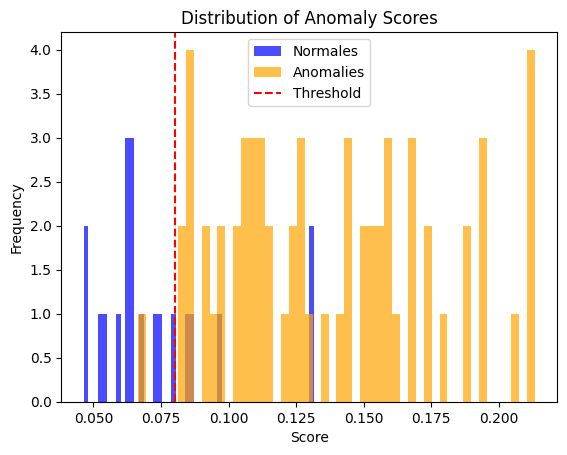

In [32]:
import matplotlib.pyplot as plt

# Convertir les scores et labels en numpy pour manipulation facile
anomaly_scores_np = anomaly_scores.cpu().numpy()
labels_np = np.array(labels)

print(labels)
# Séparer les scores selon les labels
scores_normales = anomaly_scores_np[labels_np == 0]
scores_anomalies = anomaly_scores_np[labels_np == 1]
plt.hist(scores_normales, bins=50, alpha=0.7, label="Normales", color="blue")
plt.hist(scores_anomalies, bins=50, alpha=0.7, label="Anomalies", color="orange")
plt.axvline(x=best_threshold, color='r', linestyle='--', label="Threshold")
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


euclid sans neg

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


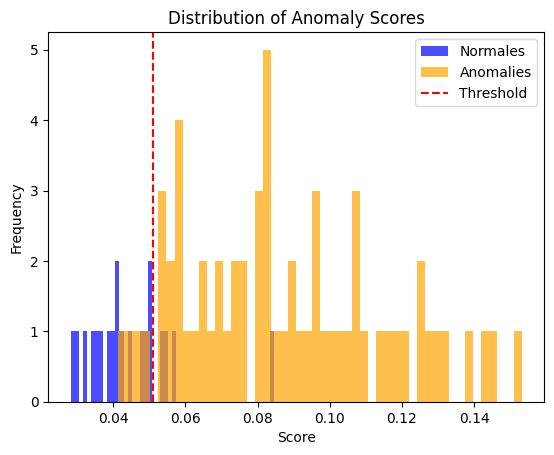

In [40]:
import matplotlib.pyplot as plt

# Convertir les scores et labels en numpy pour manipulation facile
anomaly_scores_np = anomaly_scores.cpu().numpy()
labels_np = np.array(labels)

print(labels)
# Séparer les scores selon les labels
scores_normales = anomaly_scores_np[labels_np == 0]
scores_anomalies = anomaly_scores_np[labels_np == 1]
plt.hist(scores_normales, bins=50, alpha=0.7, label="Normales", color="blue")
plt.hist(scores_anomalies, bins=50, alpha=0.7, label="Anomalies", color="orange")
plt.axvline(x=best_threshold, color='r', linestyle='--', label="Threshold")
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


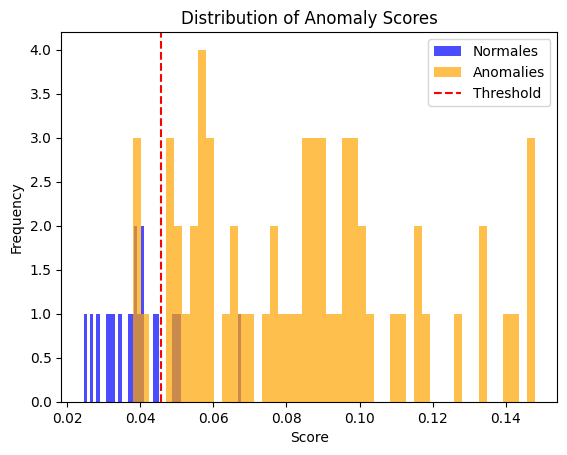

In [45]:
import matplotlib.pyplot as plt

# Convertir les scores et labels en numpy pour manipulation facile
anomaly_scores_np = anomaly_scores.cpu().numpy()
labels_np = np.array(labels)

print(labels)
# Séparer les scores selon les labels
scores_normales = anomaly_scores_np[labels_np == 0]
scores_anomalies = anomaly_scores_np[labels_np == 1]
plt.hist(scores_normales, bins=50, alpha=0.7, label="Normales", color="blue")
plt.hist(scores_anomalies, bins=50, alpha=0.7, label="Anomalies", color="orange")
plt.axvline(x=best_threshold, color='r', linestyle='--', label="Threshold")
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


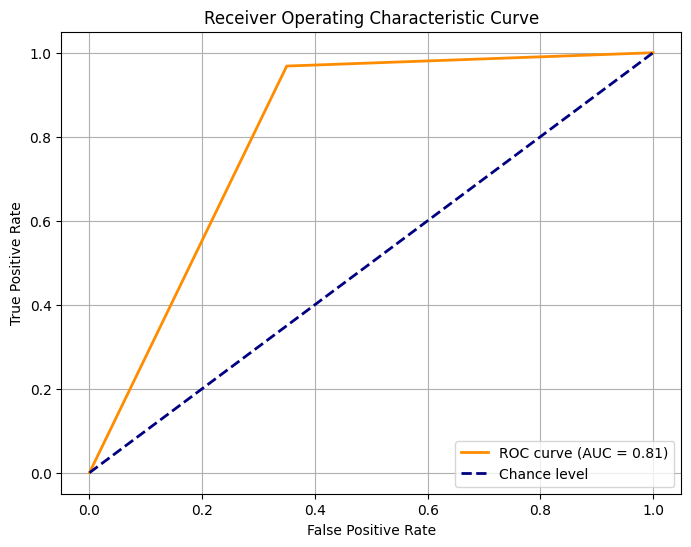

In [118]:
plot_roc_curve(labels, predictions)

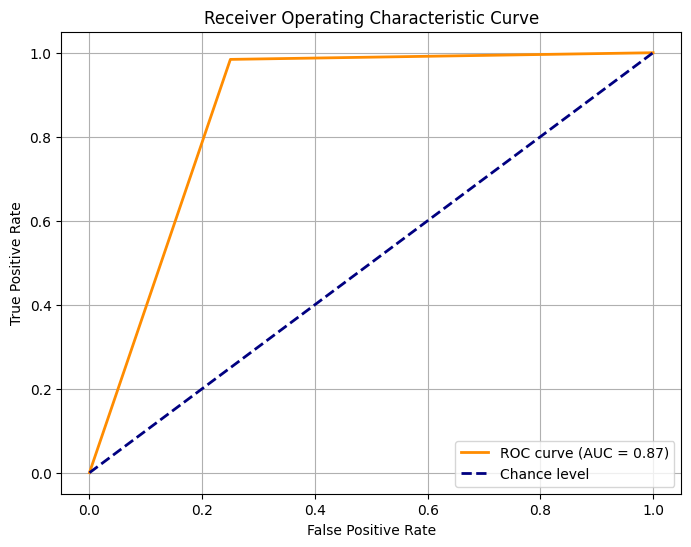

In [33]:
plot_roc_curve(labels, predictions)

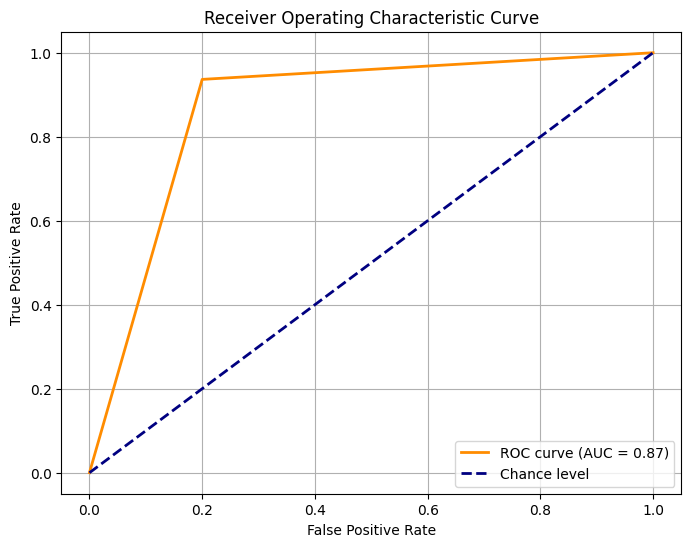

In [41]:
plot_roc_curve(labels, predictions)

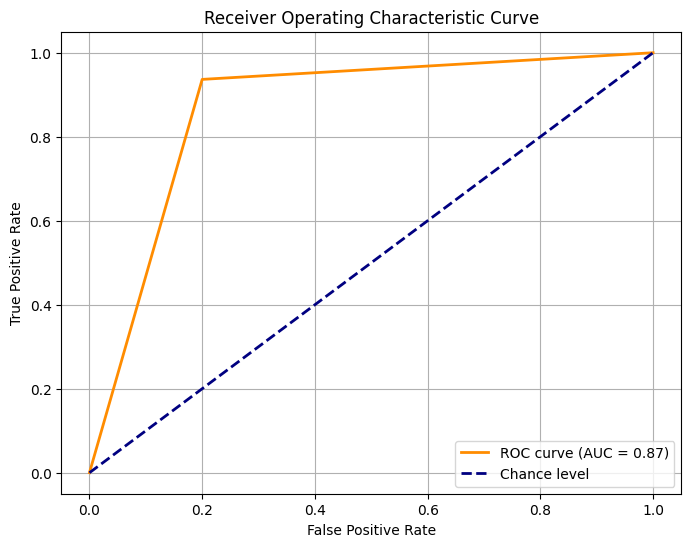

In [46]:
plot_roc_curve(labels, predictions)

# Résults

#### Color anomali

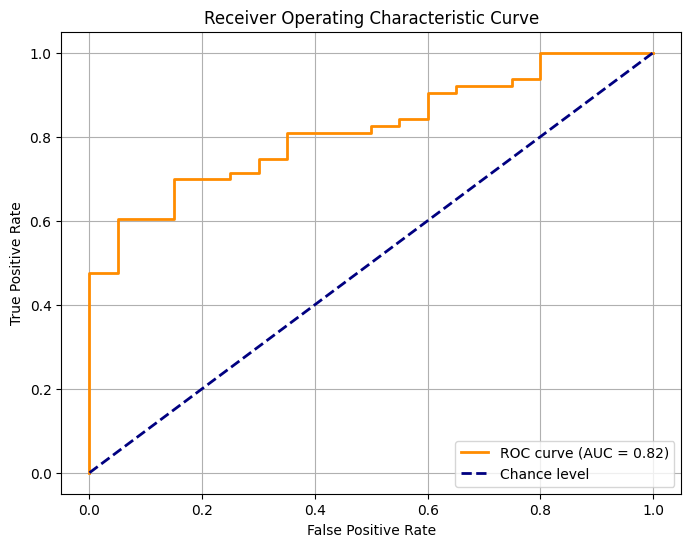

In [27]:
color_anomali = AnomalyDetectionModel(colorization_encoder)

scores, labels = color_anomali.evaluate_anomaly_detection(bottle_test_loader)

# Plotting roc curbe
plot_roc_curve(labels, scores)

#### Inpainting anomali

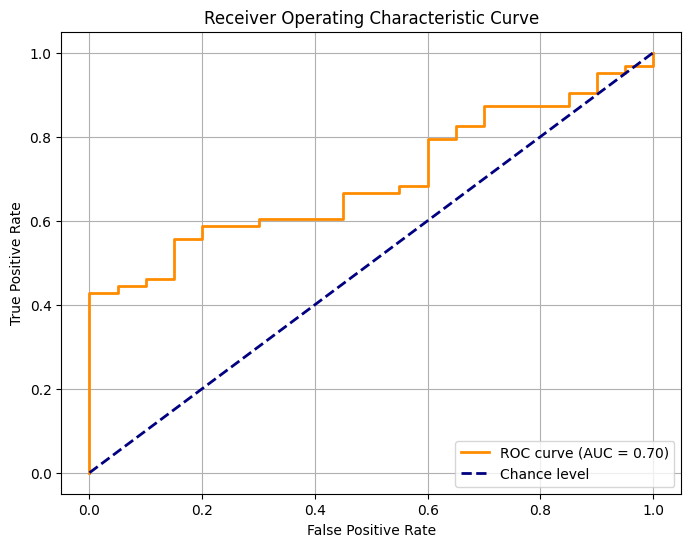

In [46]:
inpainting_anomali = AnomalyDetectionModel(inpainting_encoder)


scores, labels = inpainting_anomali.evaluate_anomaly_detection(bottle_test_loader)

# Plotting roc curbe
plot_roc_curve(labels, scores)

#### MAE anomali

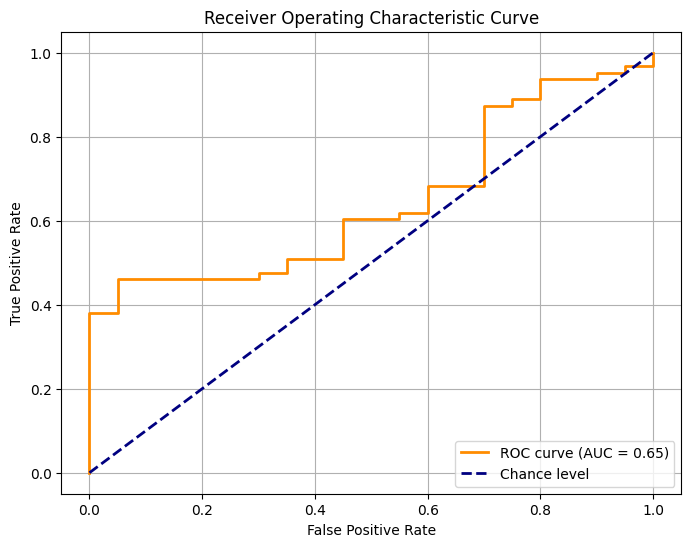

In [31]:
mae_anomali = AnomalyDetectionModel(mae_encoder)


scores, labels = mae_anomali.evaluate_anomaly_detection(bottle_test_loader)

# Plotting roc curbe
plot_roc_curve(labels, scores)